In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from array import *
import plotly.graph_objects as go


from glob import glob

What I need....

From [OpenEI](https://openei.org/doe-opendata/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states ) pkl's with loads from each TMY3 location

Need a DataFrame with: 

|  TMY3 |  City |  Heating Type | Max Daily Heat Load  | Max Daily Cooling Load  | Max Daily DHW Load | 
|---|---|---|---|---|---|
|  838593 | Tazmania  | Gas | 73 |  38 | 22|
| ...  | ...  | ...  |  ... |  ... |... |


Really just need this in its simplest form that I can do some basic calculations on and provide to Watts Water. Ideally everything can be in a single script for simplicity's sake. 

In [34]:
# Parameters For Adjustment

delta_T = 45 # [C]
standby_losses = 5 # [%]
timeFrame = 16 #[hrs] how long you'd like to shift load for. 

kh = 0.9 # hydronic coefficient
 

# Global Variables
c_p = 4.2 #[kJ/kg]
dayHours = 24

# add in later

In [53]:
# FUNCTIONS. RUN EARLY. 
def create_df(finishString):
    
    update = []
    directory = os.path.join("c:\\", "/Users/hansvonclemm/Downloads/data")
    for root,dirs,files in os.walk(directory):
        for file in files:
            if file.endswith(finishString):
                #print (file)

                li = file.split('_')
                city = li[2].split('.')[0]
                tmy3 = int(li[2].split('.')[-1])
                path = "./data/" + file
                current = pd.read_csv(path)
                cleanDF = clean_datetime(current)
                maxes = get_gas_use(cleanDF, timeFrame)
                peakLoad = cleanDF['Gas:Facility [kW](Hourly)'].max()
                
                shiftPercent = hr_shift_capability(cleanDF, peakLoad, dayHours)

                update.append([tmy3, city, maxes, peakLoad])
                
    return pd.DataFrame(update, columns=['tmy3', 'city', 'heatNeed','peakLoad'])
                
    

def to_C(F):
    C = (F-32) * (5/9)
    return (C)


def get_volume_needed(kW):
    delta_T = (toC(storage_Temp)) - (toC(usable_Temp))    
    
    adders = NG_efficiency/(100-standby_losses) # NG_eff brings volume DOWN cause 
    m = ((kW*3600) / (c_p * delta_T)) * adders 
    
    return(m/1000)

def get_t_cutout(tr):
    tCut = tr+10
    
    return (tCut)

def get_t_cutout2 (tr, kW):
    
    dTmin = kW/kh
    
    tCut = room_Temp + dTmin
    
    returntCut

def get_gas_use(df, storageTime):
    
    timeShift = str(storageTime) + 'H'
    df2 = df.resample(timeShift).sum()[['Gas:Facility [kW](Hourly)']]
    val = df2.max()

    return (val[0])

def hr_shift_capability(df, max_load, storageTime):
    timeShift = str(storageTime) + 'H'
    
    df2 = df.resample(timeShift).sum()[['Gas:Facility [kW](Hourly)']]
    
    addressed_days = df2[df2['Gas:Facility [kW](Hourly)'] < max_load]
    print (len(addressed_days))
    
    
    return(0)

In [20]:
highGasUse = create_df('HIGH.csv')
lowGasUse = create_df('LOW.csv')

lowGasUse

,tmy3,city,heatNeed,peakLoad
0,724699,Boulder-Broomfield-Jefferson,91.383212,8.119554
1,723085,Norfolk,49.020407,3.982023
2,725090,Boston-Logan,109.540300,9.397890
3,722110,Tampa,2.324928,0.342938
4,702730,Anchorage,127.980094,10.208369
5,726185,Augusta,131.967236,11.392054
6,726410,Madison-Dane,142.653273,12.243027
7,722280,Birmingham,47.337657,4.286480
8,726797,Bozeman-Gallatin,144.352730,12.359991
9,726620,Rapid,125.863445,10.556124


In [21]:
#lowGasUse['storage'] = calcVolNeeded(lowGasUse['heatNeed'])
#lowGasUse['avgLoad'] = lowGasUse['heatNeed'] / timeFrame
#lowGasUse = lowGasUse[['tmy3','city', 'heatNeed', 'peakLoad', 'avgLoad']]
lowGasUse = lowGasUse.round(1)

#highGasUse['storage'] = calcVolNeeded(highGasUse['heatNeed'])
#highGasUse['avgLoad'] = highGasUse['heatNeed'] / timeFrame
highGasUse = highGasUse.round(1)

lowGasUse

,tmy3,city,heatNeed,peakLoad
0,724699,Boulder-Broomfield-Jefferson,91.4,8.1
1,723085,Norfolk,49.0,4.0
2,725090,Boston-Logan,109.5,9.4
3,722110,Tampa,2.3,0.3
4,702730,Anchorage,128.0,10.2
5,726185,Augusta,132.0,11.4
6,726410,Madison-Dane,142.7,12.2
7,722280,Birmingham,47.3,4.3
8,726797,Bozeman-Gallatin,144.4,12.4
9,726620,Rapid,125.9,10.6


In [22]:
newPANDA = pd.merge(lowGasUse, highGasUse, on=['tmy3', 'city'])


newPANDA = newPANDA.merge(TMY3META[[
    'tmy3','Latitude','Longitude','Elev']], left_on=['tmy3'], right_on=['tmy3'])


newPANDA = newPANDA.rename(index=str, columns={"heatNeed_x": "heat_Need_LOW", "heatNeed_y": "heat_Need_HIGH"})


# newPANDA.to_csv (r'OpenEI_loads.csv', index = False, header=True)
newPANDA

,tmy3,city,heat_Need_LOW,peakLoad_x,heat_Need_HIGH,peakLoad_y,Latitude,Longitude,Elev
0,724699,Boulder-Broomfield-Jefferson,91.4,8.1,334.7,25.9,40.130,-105.240,1689
1,723085,Norfolk,49.0,4.0,242.6,18.5,36.950,-76.283,10
2,725090,Boston-Logan,109.5,9.4,411.9,32.4,42.367,-71.017,6
3,722110,Tampa,2.3,0.3,0.0,0.0,27.967,-82.533,6
4,702730,Anchorage,128.0,10.2,453.3,32.9,61.183,-150.000,35
5,726185,Augusta,132.0,11.4,464.4,33.1,44.317,-69.800,107
6,726410,Madison-Dane,142.7,12.2,480.0,33.2,43.130,-89.330,262
7,722280,Birmingham,47.3,4.3,228.9,19.7,33.567,-86.750,189
8,726797,Bozeman-Gallatin,144.4,12.4,467.6,31.9,45.800,-111.150,1349
9,726620,Rapid,125.9,10.6,444.1,30.6,44.050,-103.050,963


In [23]:
latList = newPANDA['Latitude'].to_list()
lonList = newPANDA['Longitude'].to_list()
lonList

[-105.24,
 -76.283,
 -71.017,
 -82.53299999999999,
 -150.0,
 -69.8,
 -89.33,
 -86.75,
 -111.15,
 -103.05,
 -122.25,
 -112.083,
 -122.21700000000001]

### Volume Needed:


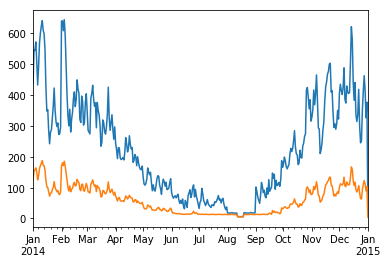

In [55]:
high = pd.read_csv('./data/USA_AK_Anchorage.Intl.AP.702730_TMY3_HIGH.csv')
low = pd.read_csv('./data/USA_AK_Anchorage.Intl.AP.702730_TMY3_LOW.csv')

peakLoad = high['Gas:Facility [kW](Hourly)'].max()



high = clean_datetime(high)
highPlot = high.resample('24H').sum()
low = clean_datetime(low)
lowPlot = low.resample('24H').sum()

highPlot['Gas:Facility [kW](Hourly)'].plot()
lowPlot['Gas:Facility [kW](Hourly)'].plot()




In [54]:
peakLoad = get_gas_use(low, timeFrame)

percent_full_addressed = hr_shift_capability(low, peakLoad, shift_for_time)

print(peakLoad)

342
127.98009360757


In [25]:
def calcVolNeeded(kW):
    
    m = (kW*3600) / (c_p * delta_T)
    return(m*.26417)
    

In [26]:
def clean_datetime(df):
    pat = '(?P<month>\d{2})/(?P<day>\d{2})  (?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2})'
    exp = df['Date/Time'].str.extract(pat,expand=True)
    exp['hour'] = exp['hour'].replace(24,0)
    exp['year'] = 2014

    df = df.set_index(pd.to_datetime(exp))

    return df

In [28]:
def get_DHW_use(df,storageTime):
    timeShift = str(storageTime) + 'H'
    df = df.resample(timeShift).sum().max()[['Wat']]

In [29]:
TMY3META = pd.read_csv("./data/TMY3_StationsMeta.csv")

TMY3META = TMY3META.rename(index=str, columns={"USAF": "tmy3", "Site Name": "city"})

TMY3META



,tmy3,city,State,Latitude,Longitude,TZ,Elev,Class,Pool
0,690150,TWENTYNINE PALMS,CA,34.300,-116.167,-8,626,II,12
1,690190,ABILENE DYESS AFB,TX,32.433,-99.850,-6,545,II,12
2,690230,WHIDBEY ISLAND NAS,WA,48.350,-122.667,-8,10,II,12
3,699604,YUMA MCAS,AZ,32.650,-114.617,-7,65,II,12
4,700197,SELAWIK,AK,66.600,-160.000,-9,8,III,11
...,...,...,...,...,...,...,...,...,...
1015,911905,LANAI,HI,20.783,-156.950,-10,409,II,12
1016,911975,KONA INTL AT KEAHOL,HI,19.733,-156.050,-10,15,III,10
1017,912120,GUAM WFO,GU,13.483,144.800,10,77,II,24
1018,912180,ANDERSEN AFB,GU,13.567,144.917,10,162,II,12


In [30]:
latList = newPANDA['Latitude'].to_list()
lonList = newPANDA['Longitude'].to_list()
#storage = newPANDA['storage_x'].to_list()



mapbox_access_token='pk.eyJ1Ijoia3Bhc2tvIiwiYSI6ImNrMjZrc2tvbjA4ZTczaGxicHRrZWRwYzMifQ.7ZJ4exw5N9ZNYXeHQi8LNg'
fig = go.Figure()
X={
    'latitude':latList,
   'longitude':lonList,
    'storage_low':storage
}

fig.add_trace(go.Scattermapbox(lat=X['latitude'],lon=X['longitude'],mode='markers'))
fig.update_layout(hovermode='closest',height=900, mapbox=go.layout.Mapbox(accesstoken=mapbox_access_token, bearing=0,
                                                              center=go.layout.mapbox.Center(lat=40.4,lon=-101.8), pitch=5, zoom=3))
fig.show()

NameError: name 'storage' is not defined

In [ ]:
### I'M AN IDIOT CHECK

high = pd.read_csv('./data/USA_ME_Augusta.AP.726185_TMY3_HIGH.csv')
high = pd.read_csv('./data/USA_ME_Augusta.AP.726185_TMY3_LOW.csv')

peakLoad = high['Gas:Facility [kW](Hourly)'].max()
print(peakLoad)




high = clean_datetime(high)
highPlot = high.resample('24H').sum()
highPlot = highPlot[highPlot.index < ("2014-03-04")]
low = clean_datetime(low)
lowPlot = low.resample('24H').sum()

highPlot['Gas:Facility [kW](Hourly)'].plot()
#lowPlot['Gas:Facility [kW](Hourly)'].plot()

In [ ]:
highPlot['Gas:Facility [kW](Hourly)']

why = highPlot[highPlot.index < ("2014-03-04")].mean()

why

high['justDHW'] = high['Gas:Facility [kW](Hourly)'] - high['Heating:Gas [kW](Hourly)']



In [ ]:

new = high.resample('24H').sum()[['justDHW', 'Heating:Gas [kW](Hourly)']]

new.plot()